# Monitoramento e Fairness

In [1]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Carregar modelo e vetor já treinados

In [2]:
modelo_path = "../model.joblib"
vetor_path = "../vectorizer.joblib"
dados_path = "../data/tweets_limpo.csv"

if not (os.path.exists(modelo_path) and os.path.exists(vetor_path)):
    raise FileExistsError("Treine e salve o modelo antes de executar!")

model = joblib.load(modelo_path)
vectorizer = joblib.load(vetor_path)
df = pd.read_csv(dados_path)
display(df.head())

,text,label,text_length
0,Adorei o produto de investimento no mercado de...,positivo,56
1,O serviço de instalacão da internet foi péssim...,negativo,62
2,Entrega rápida com atendimento excelente,positivo,40
3,Produto veio com defeito estou decepcionado,negativo,43
4,Gostei muito da qualidade,positivo,25


## Monitoramento

In [8]:
novos_textos = [
    "Muito ruim, não gostei do atendimento.",
    "A entrega foi sensacional!",
    "Não funcionou, me decepcionei",
    "Recomendo para todos, nota 10!",
    "Recomendo para todos, top!"
]

novos_df = pd.DataFrame({'text': novos_textos})
display(novos_df)

,text
0,"Muito ruim, não gostei do atendimento."
1,A entrega foi sensacional!
2,"Não funcionou, me decepcionei"
3,"Recomendo para todos, nota 10!"
4,"Recomendo para todos, top!"


In [9]:
novos_vetores = vectorizer.transform(novos_df["text"])
novos_preds = model.predict(novos_vetores)
novos_df['sentimento_predito'] = novos_preds
display(novos_df)

,text,sentimento_predito
0,"Muito ruim, não gostei do atendimento.",negativo
1,A entrega foi sensacional!,positivo
2,"Não funcionou, me decepcionei",negativo
3,"Recomendo para todos, nota 10!",positivo
4,"Recomendo para todos, top!",positivo


In [10]:
class_dict = novos_df["sentimento_predito"].value_counts(normalize=True)
print("Distribuição dos sentimentos preditos no novos dados:")
print(class_dict)

Distribuição dos sentimentos preditos no novos dados:
sentimento_predito
positivo    0.6
negativo    0.4
Name: proportion, dtype: float64


## Fairness - Vieses

In [11]:
df["text_len"]= df["text"].apply(len)
df["len_category"]= pd.cut(df["text_len"], bins=[0,50,150,1000], labels=["curto", "medio", "longo"])

In [12]:
df

,text,label,text_length,text_len,len_category
0,Adorei o produto de investimento no mercado de...,positivo,56,56,medio
1,O serviço de instalacão da internet foi péssim...,negativo,62,62,medio
2,Entrega rápida com atendimento excelente,positivo,40,40,curto
3,Produto veio com defeito estou decepcionado,negativo,43,43,curto
4,Gostei muito da qualidade,positivo,25,25,curto
5,Não funcionou como esperado.,negativo,28,28,curto
6,Fui muito bem atendido.,positivo,23,23,curto
7,Não voltarei a comprar,negativo,22,22,curto
8,Adorei o produto de investimento no mercado de...,positivo,56,56,medio
9,O serviço de instalacão da internet foi pessim...,negativo,62,62,medio


## Predições conjunto de validação

In [13]:
vetores = vectorizer.transform(df["text"])
df["pred"] = model.predict(vetores)
display(df["pred"])

0     negativo
1     negativo
2     positivo
3     negativo
4     positivo
5     negativo
6     positivo
7     negativo
8     negativo
9     negativo
10    positivo
11    negativo
12    positivo
13    negativo
14    positivo
15    positivo
16    positivo
17    negativo
Name: pred, dtype: object

## Avaliação de acurácia

In [15]:
for cat in df["len_category"].unique():
    subset = df[df["len_category"] == cat]
    if not subset.empty:
        acuracia = (subset["label"] == subset["pred"]).mean()
        print(f"Acurária para os textos {cat}: {acuracia:.2f} (N={len(subset)})")

Acurária para os textos medio: 0.50 (N=4)
Acurária para os textos curto: 1.00 (N=14)


## Desafio fairness

Matriz de confusão para textos medio: 
[[2 0]
 [2 0]]


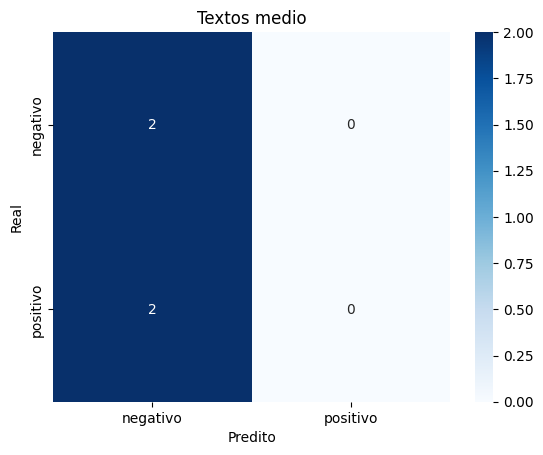

Matriz de confusão para textos curto: 
[[6 0]
 [0 8]]


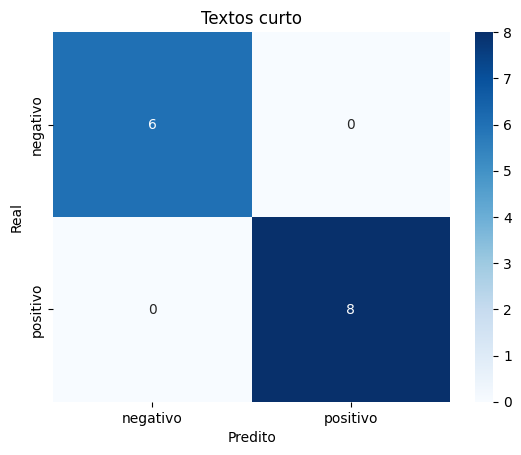

In [18]:
for cat in df["len_category"].unique():
    subset = df[df["len_category"] == cat]
    if not subset.empty:
        print(f"Matriz de confusão para textos {cat}: ")
        print(confusion_matrix(subset["label"], subset["pred"]))
        sns.heatmap(
            confusion_matrix(
                subset["label"],
                subset["pred"]
            ),
            annot=True, fmt="d",cmap="Blues",
            xticklabels=["negativo", "positivo"],
            yticklabels=["negativo", "positivo"],
        )
        plt.title(f"Textos {cat}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()